# Fitting Saturation-based Simulation Data Changes
Does models fitted on this simulation data work on real life?

In this notebook, we fit simulation data deltas using some model. But we make the simulation detectors placed at the same point as IRL detectors. Save the model. Then use it back into real life data!

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization, generate_differential_data_loaders, DifferentialCombinationDataset
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp, interpolate_exp_transform
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity
from inverse_modelling_tfo.misc.misc_training import set_seed
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [2]:
import torch
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, input, target):
        # Custom loss calculation
        loss = torch.mean(torch.abs(input - target)/target)  # Example: mean absolute error
        return loss
        


In [10]:
len(data)

50000

In [2]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')
experiment_sdd = [1.5, 3.0, 4.5, 7.0, 10.0]

# Interpolate simulation data to have same SDD as experiments
data = interpolate_exp_transform(data, experiment_sdd, [1.0, 0.8])

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,Wave Int,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Intensity,SDD
0,1.0,6.0,12.0,0.9,0.11,0.1,14.033192,1.5
1,1.0,6.0,12.0,0.9,0.11,0.1,6.455590,3.0
2,1.0,6.0,12.0,0.9,0.11,0.1,2.238021,4.5
3,1.0,6.0,12.0,0.9,0.11,0.1,-1.978824,7.0
4,1.0,6.0,12.0,0.9,0.11,0.1,-4.965775,10.0


In [5]:
data1 = create_ratio(data, True)
data2 = create_spatial_intensity(data)
sim_params = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Fetal Hb Concentration", "Fetal Saturation", "Maternal Saturation"]
data = pd.merge(data1, data2, how='inner', on=sim_params)

# data = create_ratio(data, True)

# data = create_spatial_intensity(data)

data.head() 
# NOTE: Have only 1 on at the same time!

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,1.5,3.0,4.5,7.0,10.0,1.5_1.0,3.0_1.0,4.5_1.0,7.0_1.0,10.0_1.0,1.5_2.0,3.0_2.0,4.5_2.0,7.0_2.0,10.0_2.0
0,2.0,12.0,0.9,0.11,0.100,6.769992,5.207791,3.722393,1.591282,-0.480386,3.953212,0.348625,-1.597603,-3.491634,-4.801267,14.290623,5.904000,1.487333,-2.663568,-5.371349
1,2.0,12.0,0.9,0.11,0.225,6.700053,5.176255,3.707601,1.587863,-0.481023,3.990797,0.363328,-1.592056,-3.491234,-4.800719,14.273458,5.895826,1.483319,-2.664512,-5.371311
2,2.0,12.0,0.9,0.11,0.350,6.629138,5.144348,3.692691,1.584459,-0.481700,4.030073,0.378778,-1.586185,-3.490780,-4.800129,14.256441,5.887735,1.479350,-2.665445,-5.371273
3,2.0,12.0,0.9,0.11,0.475,6.557894,5.112370,3.677821,1.581122,-0.482420,4.070347,0.394648,-1.580161,-3.490329,-4.799494,14.239542,5.879710,1.475417,-2.666369,-5.371237
4,2.0,12.0,0.9,0.11,0.600,6.487464,5.080861,3.663272,1.577942,-0.483187,4.110430,0.410377,-1.574276,-3.489975,-4.798810,14.222732,5.871737,1.471513,-2.667286,-5.371201


In [4]:
# Cleanup
data.dropna(inplace=True)
data.head()

,Wave Int,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Intensity,SDD
0,1.0,6.0,12.0,0.9,0.11,0.1,14.033192,1.5
1,1.0,6.0,12.0,0.9,0.11,0.1,6.455590,3.0
2,1.0,6.0,12.0,0.9,0.11,0.1,2.238021,4.5
3,1.0,6.0,12.0,0.9,0.11,0.1,-1.978824,7.0
4,1.0,6.0,12.0,0.9,0.11,0.1,-4.965775,10.0


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [6]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Saturation']
# y_columns = ['Maternal Hb Concentration']
# y_column = 'Fetal Hb Concentration'
y_column = 'Fetal Saturation'
fixed_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration"]
# Just to make sure I don't write stupid code
assert(len(fixed_columns) == 4), "4/5 TMPs should remain fixed. fixed_column length should be 4"
assert(y_column not in fixed_columns), "y_column is the TMP that changes. It cannot be inside fixed_columns"

x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_column] = y_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1))
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])



In [7]:
# Print Out Scaler values
# print(f'Y scale mean {y_scaler.mean_}')
# print(f'Y scale var {y_scaler.var_}')

In [8]:
data[y_column].value_counts()

-1.414214e+00    1000
-7.071068e-01    1000
-3.140185e-16    1000
 7.071068e-01    1000
 1.414214e+00    1000
Name: Fetal Saturation, dtype: int64

## Model Configuration

In [9]:
IN_FEATURES = len(x_columns) * 2    # 2 points/2 vectors coming in
OUT_FEATURES = 1
model_config = {
    # 'model_class' : SplitChannelCNN,  # Class name
    'model_class' : PerceptronReLU,  # Class name
    # 'model_params' :  [2, IN_FEATURES, 4, 5, [2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 5, [6, 3, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 7, [3, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [4, IN_FEATURES, 8, 7, [4, 2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [[IN_FEATURES, 20, 8, OUT_FEATURES]],    # Input params as an array
    'model_params' :  [[IN_FEATURES, 10, 4, 2, OUT_FEATURES]],    # Input params as an array
    'train_split' : 0.8,
    'epochs' : 25,
    # 'total_data_len': 120000,
    'total_data_len': 80000,
    'allow_zero_diff': False,
    'hyperparam_search_count': 70,
    'hyperparam_max_epoch': 10,
    'seed': 42, 
    'loss_func': nn.MSELoss,
}

In [10]:
# Custom Train Function 
def train_model2(iteration_config, epoch=model_config['hyperparam_max_epoch']):
    set_seed(model_config['seed'])
    params = {
        'batch_size': iteration_config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    # train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
    train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config["allow_zero_diff"], model_config['train_split'])
    # model = create_perceptron_model(config['model'])
    # model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    model = model_config['model_class'](*model_config['model_params'])
    # criterion = nn.MSELoss()
    criterion = model_config['loss_func']()
    optimizer = SGD(model.parameters(), lr=iteration_config["lr"], momentum=iteration_config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    
    # Report Data to Ray Tune
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [11]:
# Hyper Parameter Search 
# TODO: idk if LR should be changed. Just leave it be
iteration_config = {
    "lr" : 3e-4,
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([256, 128, 64, 32, 16, 8]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.uniform(0.9, 0.99),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=40, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=model_config['hyperparam_search_count'], resources_per_trial={"cpu": 4, "gpu": 0.05},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


2023-08-30 17:09:13,888	INFO worker.py:1621 -- Started a local Ray instance.
2023-08-30 17:09:14,826	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-08-30 17:09:14,837	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2023-08-30 17:09:15 (running for 00:00:00.56)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-08-30_17-09-14
Number of trials: 70/70 (70 PENDING)
+--------------------------+----------+-------+--------------+------------+
| Trial name               | status   | loc   |   batch_size |   momentum |
|--------------------------+----------+-------+--------------+------------|
| train_model2_9eb38_00000 | PENDING  |       |           32 |   0.906248 |
| train_model2_9eb38_00001 | PENDING  |       |           64 |   0.908446 |
| train_model2_9eb38_00002 | PENDING  |       |          256 |   0.917412 |
| train_model2_9eb38_00003 | PENDING  |       |           16 |   0.929797 |
| train_model2_9eb38_00004 | PENDING  |       |            8 |   0.

Trial name,combined_loss,train_loss,val_loss
train_model2_9eb38_00000,6.21587,2.51501,2.47151
train_model2_9eb38_00001,6.2058,2.49886,2.48345
train_model2_9eb38_00002,6.20722,2.51566,2.46743
train_model2_9eb38_00003,6.18613,2.49917,2.47528
train_model2_9eb38_00004,6.23805,2.51943,2.47598
train_model2_9eb38_00005,6.23702,2.51205,2.48284
train_model2_9eb38_00006,6.1361,2.49399,2.46035
train_model2_9eb38_00007,4.21478,2.24188,1.88002
train_model2_9eb38_00008,6.21785,2.51552,2.47179
train_model2_9eb38_00009,6.20738,2.4991,2.48385


== Status ==
Current time: 2023-08-30 17:09:25 (running for 00:00:10.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-08-30_17-09-14
Number of trials: 70/70 (54 PENDING, 16 RUNNING)
+--------------------------+----------+-----------------------+--------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status   | loc                   |   batch_size |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+----------+-----------------------+--------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_9eb38_00000 | RUNNING  | 169.237.32.34:2402813 |           32 |   0.906248 |             

2023-08-30 17:20:12,980	INFO tune.py:1148 -- Total run time: 658.14 seconds (658.11 seconds for the tuning loop).


== Status ==
Current time: 2023-08-30 17:20:12 (running for 00:10:58.12)
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: -6.21653426896612 | Iter 5.000: -6.206941634326071
Logical resource usage: 4.0/64 CPUs, 0.05/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-08-30_17-09-14
Number of trials: 70/70 (70 TERMINATED)
+--------------------------+------------+-----------------------+--------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                   |   batch_size |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+-----------------------+--------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_9eb38_00000 | TERMINATED | 169.237.32.34:2402813 |           32 |   0.906248 | 

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [12]:
best_trial.config

{'lr': 0.0003, 'batch_size': 32, 'momentum': 0.9858148652167854}

In [13]:
model_config

{'model_class': inverse_modelling_tfo.models.custom_models.PerceptronReLU,
 'model_params': [[20, 10, 4, 2, 1]],
 'train_split': 0.8,
 'epochs': 25,
 'total_data_len': 80000,
 'allow_zero_diff': False,
 'hyperparam_search_count': 70,
 'hyperparam_max_epoch': 10,
 'seed': 42,
 'loss_func': torch.nn.modules.loss.MSELoss}

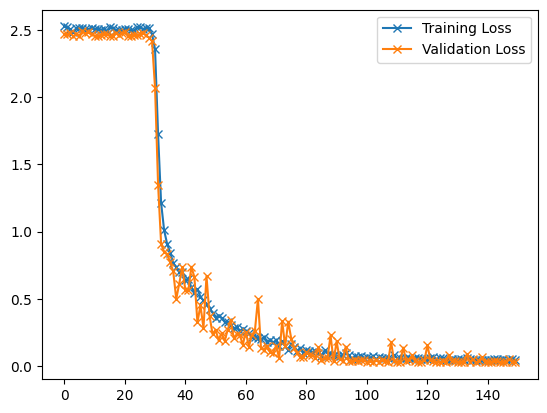

In [30]:
# Train Model with the given params.
set_seed(model_config['seed'])
params = {
    'batch_size': 8, 'shuffle': True, 'num_workers': 2
}
params['batch_size'] = best_trial.config['batch_size']
train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config["allow_zero_diff"], model_config['train_split'])
# train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, 140000, model_config["allow_zero_diff"], model_config['train_split'])

model = model_config['model_class'](*model_config['model_params'])
# criterion = nn.MSELoss()
criterion = model_config['loss_func']()
# criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
optimizer = SGD(model.parameters(), lr=0.0003, momentum=0.9)
# optimizer = SGD(model.parameters(), lr=best_trial.config['lr'], momentum=best_trial.config['momentum'])
# CUDA_VISIBLE is already set to only see one GPU
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=150, gpu_to_use=0)
# train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=model_config['epochs'], gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [31]:
print(f'Train MSE : {train_loss[-1]}, Val MSE : {validation_loss[-1]}')

Train MSE : 0.0450835753493011, Val MSE : 0.03293785521946847


In [42]:
x_data = DifferentialCombinationDataset(data, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config['allow_zero_diff'])
truth_column = []
prediction_column = []
loss_column = []
tissue_fixed_params = []

with torch.no_grad():
    for i, current_sample in enumerate(x_data):
        inputs, labels = current_sample
        inputs = inputs.view(1, -1).cuda()
        labels = labels.view(1, -1).cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Bookkeeping
        truth_column.append(labels.item())
        prediction_column.append(outputs.item())
        loss_column.append(loss.item())
        tissue_fixed_params.append(x_data.split_fixed_columns[x_data.randomized_indices_list[i]])


tissue_fixed_params = np.array(tissue_fixed_params)
truth_column = np.array(truth_column).reshape(-1, 1)
prediction_column = np.array(prediction_column).reshape(-1, 1)
loss_column = np.array(loss_column).reshape(-1, 1)

# un-normalize
truth_column = y_scaler.scale_ * truth_column
prediction_column = y_scaler.scale_ * prediction_column
absolute_error = np.abs(truth_column - prediction_column)


merged = np.hstack([tissue_fixed_params, truth_column, prediction_column, loss_column, absolute_error])
merged_df = pd.DataFrame(merged, columns=fixed_columns + ['Truth', 'Predicted', "Train Error", "Absolute Error"])
merged_df.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Truth,Predicted,Train Error,Absolute Error
0,16.0,15.0,0.975,0.170,-0.125,-0.112583,0.004934,0.012417
1,10.0,12.0,0.975,0.170,0.125,0.155587,0.029937,0.030587
2,8.0,15.0,0.975,0.110,-0.250,-0.237141,0.005292,0.012859
3,6.0,13.0,0.900,0.170,-0.250,-0.293943,0.061791,0.043943
4,16.0,15.0,1.000,0.155,0.500,0.474948,0.020082,0.025051


Text(0, 0.5, 'Count')

<Figure size 640x480 with 0 Axes>

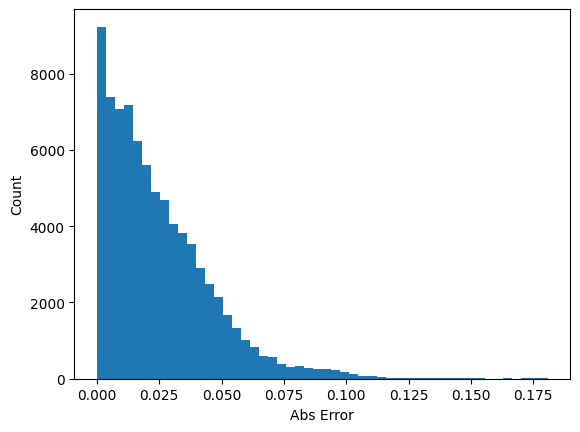

In [43]:
plt.figure()
plt.figure('Error Distribution')
plt.hist(merged_df['Absolute Error'], 50)
plt.xlabel('Abs Error')
plt.ylabel('Count')

In [34]:
merged_df['%Error'] = np.abs((merged_df['Truth'] - merged_df['Predicted'])) / merged_df['Truth'] * 100.

In [35]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = merged_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]
# worst_errors = merged_df['%Error'].argsort()[::-1][:VIEW_TOP_N]
with pd.option_context("display.max_rows", None):
    display(merged_df.iloc[worst_errors, :])

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Truth,Predicted,Train Error,Absolute Error,%Error
2872,12.0,16.0,0.900,0.11,-0.500,-0.319103,1.047164,0.180897,-36.179488
53748,12.0,16.0,0.900,0.11,-0.500,-0.319103,1.047164,0.180897,-36.179488
35557,12.0,16.0,0.900,0.11,-0.500,-0.319103,1.047164,0.180897,-36.179488
10661,12.0,16.0,0.900,0.11,-0.500,-0.319103,1.047164,0.180897,-36.179488
38223,12.0,16.0,0.900,0.11,-0.500,-0.319103,1.047164,0.180897,-36.179488
54626,12.0,15.0,0.900,0.11,-0.500,-0.319619,1.041190,0.180381,-36.076131
33738,12.0,15.0,0.900,0.11,-0.500,-0.319619,1.041190,0.180381,-36.076131
5572,12.0,15.0,0.900,0.11,-0.500,-0.319619,1.041190,0.180381,-36.076131
46694,12.0,16.0,0.925,0.11,-0.500,-0.320867,1.026834,0.179133,-35.826567
55788,12.0,15.0,0.925,0.11,-0.500,-0.325173,0.978062,0.174827,-34.965372


In [20]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.0123742]
Validation Error(non-normalized): [0.00740332]


In [21]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PerceptronReLU                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       210
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       44
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       10
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       3
│    └─Flatten: 2-8                      --
Total params: 267
Trainable params: 267
Non-trainable params: 0

In [22]:
merged_df['Truth'].value_counts()

 0.125    16038
-0.125    16011
-0.250    12097
 0.250    11907
-0.375     8070
 0.375     7855
 0.500     4128
-0.500     3894
Name: Truth, dtype: int64

In [36]:
## Save Model
# torch.save(model.state_dict(), r'../models/fsat_delta_5det_v1')

## Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()